# Q-Learning Agents Playing Tic Tac Toe

In [1]:
import numpy as np
import pickle
import pygame
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy

pygame 2.2.0 (SDL 2.0.22, Python 3.9.14)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Q-Learning Agent Class

In [2]:
class Agent:
    
    def __init__(self, alpha=0.3, gamma=0.9, epsilon=0.2, mark="X", q_table=np.ones([3**9, 9])):
        self.q_table = deepcopy(q_table)
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.mark = mark
        
    # Compress a tic tac toe board into a single number
    # We have 3^9 possible board states = 19683
    def encode_state(self, board):
        state = 0
        for i, mark in enumerate(board):
            if mark == 'X':
                state += 3**(8-i) * 2
            elif mark == 'O':
                state += 3**(8-i)
        return state
    
    # Function to update variable state
    def set_state(self, board):
        self.state = self.encode_state(board)
    
    # Function to update variable next_state
    def set_next_state(self, board):
        self.next_state = self.encode_state(board)

    # Function to return the available actions
    def get_actions(self, board):
        return [i for i in range(len(board)) if board[i] == " "]

    # Function to choose action based on epsilon-greedy policy
    def choose_action(self, board):
        valid_actions = self.get_actions(board)
        # Exploration strategy: choose a random action:
        if np.random.uniform(0, 1) < self.epsilon:
            self.action =  np.random.choice(valid_actions)
        # Select the best action given the current state of the agent:
        else:
            q_values = self.q_table[self.state]
            max_q = np.max(q_values[valid_actions])
            self.action = np.random.choice([a for a in valid_actions if q_values[a] == max_q])

    # Update the Q-value for a state-action pair
    def update_Q(self, reward, board):
        old_value = self.q_table[(self.state, self.action)]
        valid_actions = self.get_actions(board)
        if valid_actions:
            next_max = max(self.q_table[self.next_state][valid_actions])
        else:
            next_max = 0.0
        new_value = (1 - self.alpha) * old_value + self.alpha * (reward + self.gamma * next_max)
        self.q_table[(self.state, self.action)] = new_value
    
    # Function to save Q-Table
    def save_q_table(self, file_name):  #save table
        with open(file_name, 'wb') as handle:
            pickle.dump(self.q_table, handle)

    # Function to load Q-table
    def load_q_table(self, file_name): # load table
        with open(file_name, 'rb') as handle:
            self.q_table = pickle.load(handle)


## Game Class

In [3]:
class Game:
    
    def __init__(self):
        self.board = board = [' ']*9
        self.winner = None
        self.player = "X"
        self.agents_move = []

    # Function to reset the game 
    def reset_game(self):
        self.board = board = [' ']*9
        self.winner = None
        self.player = "X"
        self.agents_move = []

    # Function to check for a winner
    def check_win(self):
        for row in range(3):
            if self.board[row * 3 + 0] == self.board[row * 3 + 1] == self.board[row * 3 + 2] != ' ':
                return self.board[row * 3 + 0]
        for column in range(3):
            if self.board[column + 0] == self.board[column + 3] == self.board[column + 6] != ' ':
                return self.board[column + 0]
        if self.board[0] == self.board[4] == self.board[8] != ' ':
            return self.board[0]
        if self.board[2] == self.board[4] == self.board[6] != ' ':
            return self.board[2]
        if ' ' not in self.board:
            return "Tie"
        return None

    # Function to make a move
    def play_move(self, place):
        if self.board[place] == ' ':
            self.board[place] = self.player
            self.player = "O" if self.player == "X" else "X"

    def init_pygame(self):
        # Initialize Pygame
        pygame.init()
        # Define the window dimensions
        WINDOW_SIZE = (300, 400)
        # Set up the window display
        self.screen = pygame.display.set_mode(WINDOW_SIZE)
        # Set the title of the window
        pygame.display.set_caption("Tic Tac Toe Game")
        # Define the colors
        self.BLACK = (0, 0, 0)
        self.WHITE = (255, 255, 255)
        self.GRAY = (128, 128, 128)
        self.RED = (255, 0, 0)
        self.BLUE = (0, 0, 255)
        # Define the font for the text
        self.font = pygame.font.Font(None, 50)
        self.font_2 = pygame.font.Font(None, 40)
        # Background  
        self.bg = pygame.image.load("bg.png")
        

    # Draw the board using GUI (with pygame) 
    def draw_board_gui(self):
        self.screen.blit(self.bg, (0, 0))
        for row in range(3):
            for column in range(3):
                pygame.draw.rect(self.screen, self.BLACK, [(10 + 100 * column), (10 + 100 * row + 50), 80, 80], 2)
                if self.board[3 * row  + column] == 'X':
                    text = self.font.render(self.board[3 * row  + column], True, self.RED)
                    self.screen.blit(text, (35 + 100 * column, 35 + 100 * row + 50))
                elif self.board[3 * row  + column]  == 'O':
                    text = self.font.render(self.board[3 * row  + column], True, self.BLUE)
                    self.screen.blit(text, (35 + 100 * column, 35 + 100 * row + 50))
        if self.winner == 'X' or self.winner == 'O':
            COLOR = self.RED if self.winner == 'X' else self.BLUE
            text = self.font.render(self.winner + " wins!", True, COLOR)
            self.screen.blit(text, (100, 360))
        elif self.winner == 'Tie':
            text = self.font.render("It's a Draw!", True, self.BLACK)
            self.screen.blit(text, (100, 360))
        restart_button = pygame.draw.rect(self.screen, self.GRAY, [90, 10, 120, 30], 2)
        restart_text = self.font_2.render("Restart", True, self.GRAY)
        self.screen.blit(restart_text, (100, 15))

    # Draw the board using GUI (with pygame) 
    def draw_board_with_q_values(self, q_values, agent_mark):
        self.screen.blit(self.bg, (0, 0))
        for row in range(3):
            for column in range(3):
                pygame.draw.rect(self.screen, self.BLACK, [(10 + 100 * column), (10 + 100 * row + 50), 80, 80], 2)
                if self.board[3 * row  + column] == agent_mark:
                    if (3 * row  + column) not in self.agents_move:
                        self.agents_move.append(3 * row  + column)
                    elif (3 * row  + column) not in self.agents_move[:-1]:
                        text =  self.font_2.render(f"{q_values[3 * row  + column]:.2f}", True, self.RED)
                        self.screen.blit(text, (25 + 100 * column, 35 + 100 * row + 50))
                    else:
                        text =  self.font.render(agent_mark, True, self.RED)
                        self.screen.blit(text, (35 + 100 * column, 35 + 100 * row + 50))
                elif self.board[3 * row  + column] != ' ':
                    text = self.font.render(self.board[3 * row  + column], True, self.BLUE)
                    self.screen.blit(text, (35 + 100 * column, 35 + 100 * row + 50))
                else:
                    text = self.font_2.render(f"{q_values[3 * row  + column]:.2f}", True, self.BLACK)
                    self.screen.blit(text, (25 + 100 * column, 35 + 100 * row + 50))
        if self.winner == 'X' or self.winner == 'O':
            COLOR = self.RED if self.winner == 'X' else self.BLUE
            text = self.font.render(self.winner + " wins!", True, COLOR)
            self.screen.blit(text, (100, 360))
        elif self.winner == 'Tie':
            text = self.font.render("It's a Draw!", True, self.BLACK)
            self.screen.blit(text, (100, 360))
        restart_button = pygame.draw.rect(self.screen, self.GRAY, [90, 10, 120, 30], 2)
        restart_text = self.font_2.render("Restart", True, self.GRAY)
        self.screen.blit(restart_text, (100, 15))

    # Draw the board without GUI 
    def draw_board(self):
        print(self.board[0:3])
        print(self.board[3:6])
        print(self.board[6:9])
        print('')
            
    # Game loop for 2 human players
    def play_game_two_players(self, use_gui=False):
        self.reset_game()
        # Game loop
        if use_gui:
            self.init_pygame()
            running = True
            while running:
                for event in pygame.event.get():
                    if event.type == pygame.QUIT:
                        running = False
                    elif event.type == pygame.MOUSEBUTTONDOWN:
                        x, y = pygame.mouse.get_pos()
                        if y < 50 and 90 <= x <= 210:
                            self.reset_game()
                        else:
                            row = (y - 50) // 100
                            column = x // 100
                            if self.board[3 * row  + column] == ' ':
                                self.play_move(place = 3 * row  + column)
                self.winner = self.check_win()
                self.draw_board_gui()
                pygame.display.update()
            # Quit Pygame
            pygame.quit()
        else:
            running = True
            while running:
                for event in pygame.event.get():
                    if event.type == pygame.QUIT:
                        running = False
                    elif event.type == pygame.MOUSEBUTTONDOWN:
                        x, y = pygame.mouse.get_pos()
                        if y < 50 and 90 <= x <= 210:
                            self.reset_game()
                        else:
                            row = (y - 50) // 100
                            column = x // 100
                            if self.board[3 * row  + column] == ' ':
                                self.play_move(place = 3 * row  + column)
                self.winner = self.check_win()
                self.draw_board_gui()
                pygame.display.update()
            # Quit Pygame
            pygame.quit()

    # Game loop: human vs AI
    def play_against_AI(self, agent, use_gui, show_q_values=False):
        self.reset_game()
        agent.epsilon = 0
        if use_gui:
            self.init_pygame()
            running = True
            while running:
                for event in pygame.event.get():
                    if event.type == pygame.QUIT:
                        running = False
                    elif event.type == pygame.MOUSEBUTTONDOWN:
                        x, y = pygame.mouse.get_pos()
                        if y < 50 and 90 <= x <= 210:
                            self.reset_game()
                        else:
                            if self.player != agent.mark:
                                row = (y - 50) // 100
                                column = x // 100
                                if self.board[3 * row  + column] == ' ':
                                    self.play_move(place = 3 * row  + column)
                if self.player == agent.mark and self.check_win() == None:
                    agent.set_state(self.board)
                    agent.choose_action(self.board)
                    self.play_move(agent.action)         
                self.winner = self.check_win()
                if show_q_values:
                    self.draw_board_with_q_values(agent.q_table[agent.state], agent.mark)
                else:
                    self.draw_board_gui()
                pygame.display.update()
            # Quit Pygame
            pygame.quit()
        else:
            running = True
            while running:
                if agent.mark == 'X':
                    agent.set_state(self.board)
                    agent.choose_action(self.board)
                    self.play_move(agent.action)
                else:
                    action = int(input('Enter your move (0-8): '))
                    while self.board[action] != ' ':
                        action = int(input('Invalid move. Enter your move (0-8): '))
                    self.play_move(action)
                self.draw_board()
                if self.check_win() != None:
                    running = False
                else:
                    if agent.mark == 'O':
                        agent.set_state(self.board)
                        agent.choose_action(self.board)
                        self.play_move(agent.action)
                    else:
                        action = int(input('Enter your move (0-8): '))
                        while self.board[action] != ' ':
                            action = int(input('Invalid move. Enter your move (0-8): '))
                        self.play_move(action)
                    self.draw_board()
                    if self.check_win() != None:
                        running = False
            # Determine winner
            self.winner = self.check_win()
            if self.winner != agent.mark and self.winner != "Tie":
                print('You win!')
            elif self.check_win() == agent.mark:
                print('AI wins!')
            else:
                print('It is a draw!')
            print('')
            self.draw_board()

## Function to train two Q-learning agents

In [4]:
def train_two_agents(agent_1, agent_2, episodes): 
    # train Q-table
    game = Game()
    agent_1.mark="X"
    agent_2.mark="O"
    results = np.zeros(episodes)
    for episode in range(episodes):
        game.reset_game()
        done = False
        first_move_1 = True
        first_move_2 = True
        game.player = "X"
        while True:
            if game.player == 'X':
                if not first_move_1:
                    agent_1.set_next_state(game.board) 
                    agent_1.update_Q(0, game.board)
                else:
                    first_move_1 = False
                # Observation: The agent needs to observe the current state of the environment.
                agent_1.set_state(game.board)
                # Action: The agent chooses to act in the environment. 
                agent_1.choose_action(game.board)
                game.play_move(agent_1.action) 
                agent_1.set_next_state(game.board)     
                if game.check_win() != None:
                    # Update: After the action has been taken, it's time to update the Q-table with the results.
                    if game.check_win() == agent_1.mark:
                        # agent 1 wins 
                        agent_1.update_Q(1, game.board)
                        agent_2.update_Q(-1, game.board)    
                        results[episode] = 1
                    else:
                        # it's a tie
                        agent_1.update_Q(0.5, game.board)
                        agent_2.update_Q(0.5, game.board) 
                        results[episode] = 0.5
                    break
            else:
                if not first_move_2:
                    agent_2.set_next_state(game.board) 
                    agent_2.update_Q(0, game.board)
                else:
                    first_move_2 = False
                agent_2.set_state(game.board)
                agent_2.choose_action(game.board)
                game.play_move(agent_2.action)
                agent_2.set_next_state(game.board)  
                if game.check_win() != None:
                    # update Q-table
                    if game.check_win() == agent_2.mark:
                        # agent 2 wins 
                        agent_1.update_Q(-1, game.board)
                        agent_2.update_Q(1, game.board)   
                        results[episode] = -1 
                    else:
                        # it's a tie
                        agent_1.update_Q(0.5, game.board)
                        agent_2.update_Q(0.5, game.board)
                        results[episode] = 0.5
                    break
    return results


## Train and Test Agents

In [5]:
eps = 100000
agent_1 = Agent(mark='X')
agent_2 = Agent(mark='O')
results = train_two_agents(agent_1, agent_2, episodes=eps)

In [6]:
agent_1.save_q_table('agents/agent_player_x')
agent_2.save_q_table('agents/agent_player_o')

In [7]:
agent_1 = Agent(mark='X')
agent_2 = Agent(mark='O')
agent_1.load_q_table('agents/agent_player_x')
agent_2.load_q_table('agents/agent_player_o')

In [8]:
game = Game()
game.play_against_AI(agent_1, use_gui=True)

In [9]:
game.play_against_AI(agent_2, use_gui=True)

In [10]:
game.play_against_AI(agent_1, use_gui=True, show_q_values=True)

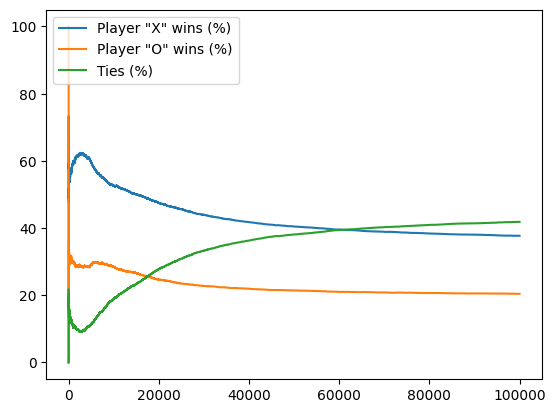

In [11]:
wins = np.zeros(eps)
loses = np.zeros(eps)
ties = np.zeros(eps)
wins_count = 0
loses_count = 0
ties_count = 0
for i in range(eps):
    if results[i] == 1:
        wins_count += 1
    elif results[i] == -1:
        loses_count += 1
    else:
        ties_count += 1
    wins[i] = wins_count/(i+1) * 100
    loses[i] = loses_count/(i+1) * 100
    ties[i] = ties_count/(i+1) * 100
plt.plot(wins, label='Player "X" wins (%)')
plt.plot(loses, label='Player "O" wins (%)')
plt.plot(ties, label='Ties (%)')
plt.legend(loc="upper left")